In [2]:
import matplotlib.pyplot as plt
import Camera
import cv2 as cv
import numpy as np
import glob
from CameraPPTTypes import F32, CV_Matrix
from typing import Sequence

# turns out we need have only opencv-contrib-python installed not opencv-python
# https://github.com/opencv/opencv/issues/23493

# Generate Charuco

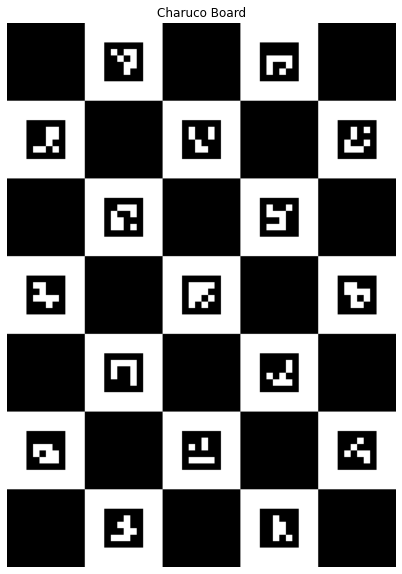

Charuco board saved to ./blender_camera_calibration/charuco_board.png


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_charuco_board(squares_x, squares_y, square_length, marker_length, dictionary_id, output_file):
    # Define the dictionary used to create markers
    aruco_dict = cv2.aruco.getPredefinedDictionary(dictionary_id)

    # Create the Charuco board using the new API
    charuco_board = cv2.aruco.CharucoBoard((squares_x, squares_y), square_length, marker_length, aruco_dict)

    # Draw the Charuco board
    board_image = charuco_board.generateImage((int(squares_x * square_length * 1000), int(squares_y * square_length * 1000)))

    # Save the Charuco board to a file
    cv2.imwrite(output_file, board_image)

    # Display the Charuco board
    plt.figure(figsize=(10, 10))
    plt.imshow(board_image, cmap='gray')
    plt.title('Charuco Board')
    plt.axis('off')
    plt.show()

    print(f"Charuco board saved to {output_file}")

# Define the parameters for the Charuco board
squares_x = 5  # Number of chessboard squares along the x-axis
squares_y = 7  # Number of chessboard squares along the y-axis
square_length = 0.4  # Length of a square in meters
marker_length = 0.2  # Length of the Aruco marker inside the square in meters
dictionary_id = cv2.aruco.DICT_4X4_50  # Dictionary id to use (e.g., DICT_6X6_250)
output_file = "./blender_camera_calibration/charuco_board.png"  # Output file path

# Generate and save the Charuco board
generate_charuco_board(squares_x, squares_y, square_length, marker_length, dictionary_id, output_file)


# Calibrate using Charuco

In [8]:
# Define the dictionary used to create markers
aruco_dict = cv2.aruco.getPredefinedDictionary(dictionary_id)

# Create the Charuco board using the new API
charuco_board = cv2.aruco.CharucoBoard((squares_x, squares_y), square_length, marker_length, aruco_dict)

# Initialize the Charuco detector
charucodetector = cv.aruco.CharucoDetector(charuco_board)

# Prepare to capture corners
all_corners = []
all_ids = []
image_size = None

# Load the images
images = glob.glob('./blender_camera_calibration/Camera*.png')

for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Detect the charuco board
    charuco_corners, charuco_ids, marker_corners, marker_ids = charucodetector.detectBoard(gray)
    
    if charuco_ids is not None:
        all_corners.append(charuco_corners)
        all_ids.append(charuco_ids)
        
        # Draw and display the markers
        img = cv.aruco.drawDetectedMarkers(img, marker_corners, marker_ids)
        img = cv.aruco.drawDetectedCornersCharuco(img, charuco_corners, charuco_ids)
        
        cv.imshow('Charuco Board', img)
        cv.waitKey(500)

cv.destroyAllWindows()

# Calibration
if len(all_corners) > 0:
    camera_matrix_init = np.array([[1000., 0., img.shape[1] / 2.],
                                   [0., 1000., img.shape[0] / 2.],
                                   [0., 0., 1.]])
    dist_coeffs_init = np.zeros((5, 1))
    
    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv.aruco.calibrateCameraCharuco(
        charucoCorners=all_corners,
        charucoIds=all_ids,
        board=charuco_board,
        imageSize=(gray.shape[1], gray.shape[0]),
        cameraMatrix=camera_matrix_init,
        distCoeffs=dist_coeffs_init
    )
    
    print("Calibration successful:")
    print("Camera Matrix:\n", camera_matrix)
    print("Distortion Coefficients:\n", dist_coeffs)
else:
    print("Not enough corners detected for calibration.")



Calibration successful:
Camera Matrix:
 [[2.66388801e+03 0.00000000e+00 9.59194476e+02]
 [0.00000000e+00 2.66592651e+03 5.44866862e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients:
 [[ 6.79830017e-03]
 [-5.85803172e-01]
 [-1.01309557e-04]
 [-1.20228581e-04]
 [ 2.09228679e+01]]


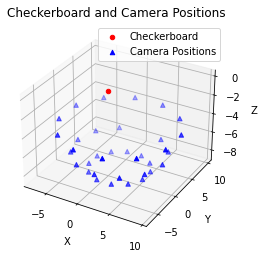

In [10]:
def get_camera_positions(rvecs: Sequence[CV_Matrix], tvecs: Sequence[CV_Matrix]) -> np.ndarray:
    camera_positions: list[np.ndarray] = []
    for rvec, tvec in zip(rvecs, tvecs):
        R, _ = cv.Rodrigues(rvec)  # Convert rotation vector to matrix
        camera_position = -R.T @ tvec  # Camera position in world coordinates
        camera_positions.append(camera_position.flatten())
    return np.array(camera_positions)


camera_positions: np.ndarray = get_camera_positions(rvecs, tvecs)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Plot the checkerboard at the origin
ax.scatter(0, 0, 0, c='r', marker='o', label='Checkerboard')

# Plot the camera positions
ax.scatter(
    camera_positions[:, 0], 
    camera_positions[:, 1], 
    camera_positions[:, 2], 
    c='b', marker='^', label='Camera Positions')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
ax.set_title('Checkerboard and Camera Positions')

plt.show()